In [1]:
import datetime
import pandas
import psycopg2
import os
import matplotlib.pyplot as plt
import shutil
import numpy
import seaborn


conn = psycopg2.connect(host = '127.0.0.1' , user = 'postgres' , dbname = 'postgres' , password = 'mon3636a')
cur = conn.cursor()
pandas.set_option('display.max_rows',5000)
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

In [2]:
semi_list = ('3C賣場電子產業',  'IC生產製造電子產業',  'IC設計服務電子產業',  'LED電子產業',  'PCB電子產業',  'PC及NB及平板電子產業',  
             '主機板電子產業',  '光學元件或組裝電子產業',  '光電設備電子產業',  '其他光電電子產業',  '其他網通電子產業',  '其他零組件電子產業',  
             '其他電子或零件電子產業',  '其他電腦週邊電子產業',  '太陽能電子產業',  '安全監控電子產業',  '工業電腦電子產業',  '手機相關電子產業',  
             '機殼電子產業',  '消費電子或電器電子產業',  '系統整合電子產業',  '組裝代工電子產業',  '網站經營及電商電子產業',  '網通設備組件電子產業',  
             '被動元件電子產業',  '設備或廠務工程電子產業',  '軟體設計電子產業',  '遊戲軟體電子產業',  '電信服務電子產業',  '電子組件買賣電子產業',  
             '電子設備買賣電子產業',  '電子連接相關電子產業',  '電池或電源電子產業',  '電競產業',  '電腦週邊配件電子產業',  '面板業電子產業')

In [3]:
ALL = pandas.read_sql("select date , date_no , type , topic , qty , amt , qty20/20000 qty20 , amt20/200000 amt20,investor from ods.exponent_insti \
                  where date_no >= (select max(date_no) from work_date)-19 \
                  order by type , topic , date", con = conn)
data_date = '{:0>4}{:0>2}{:0>2}'.format(ALL['date'].max().year,ALL['date'].max().month,ALL['date'].max().day)
ALL.date = ALL.apply(lambda x : '{:0>2}/{:0>2}'.format(x['date'].month,x['date'].day) ,axis=1)
tmp = ALL[['date','type','topic','amt20','investor']]
tmp.loc[:,'amt_trend'] = -0.000
tmp.loc[:,'DoD'] = 0

/home/buneo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/buneo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [4]:
cal_topic = pandas.DataFrame(columns = ['date','type','topic','amt20','investor','amt_trend']) 
for investor in tmp['investor'].unique():
    for t in tmp['topic'].unique():
        mask1 = tmp['investor'] == investor
        mask2 = tmp['topic'] == t
        max_amt = tmp[mask1 & mask2]['amt20'].abs().max()
        topic_df = tmp[mask1&mask2]
        for i in range(len(topic_df)):
            topic_df['amt_trend'].iloc[i] = topic_df['amt20'].iloc[i]/max_amt
            if i > 0:
                if topic_df['amt20'].iloc[i] > topic_df['amt20'].iloc[i-1]:
                    topic_df['DoD'].iloc[i] = 0.3
                elif topic_df['amt20'].iloc[i] == topic_df['amt20'].iloc[i-1]:
                    topic_df['DoD'].iloc[i] = 0
                elif topic_df['amt20'].iloc[i] < topic_df['amt20'].iloc[i-1]:
                    topic_df['DoD'].iloc[i] = -0.3
            
        cal_topic = pandas.concat([topic_df,cal_topic])
fi_topic = cal_topic[cal_topic['investor'] == 'Foreign investor']
it_topic = cal_topic[cal_topic['investor'] == 'Investment trust']

fi_stock = fi_topic[fi_topic['type']=='stock']
fi_otc   = fi_topic[fi_topic['type']=='otc']
fi_semi = fi_topic[fi_topic['type']=='semi']
fi_topic = fi_topic[fi_topic['type']=='topic']


it_stock = it_topic[it_topic['type']=='stock']
it_otc   = it_topic[it_topic['type']=='otc']
it_semi = it_topic[it_topic['type']=='semi']
it_topic = it_topic[it_topic['type']=='topic']


/home/buneo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-4-4ab349dd7a56>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['amt_trend'].iloc[i] = topic_df['amt20'].iloc[i]/max_amt
<ipython-input-4-4ab349dd7a56>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['DoD'].iloc[i] = 0.3
<ipython-input

In [5]:
fi_stock_dod = fi_stock.pivot_table(values = 'DoD',index = 'topic',columns = 'date')
fi_otc_dod   = fi_otc.pivot_table(values = 'DoD',index = 'topic',columns = 'date')
fi_topic_dod = fi_topic.pivot_table(values = 'DoD',index = 'topic',columns = 'date')
fi_semi_dod = fi_semi.pivot_table(values = 'DoD',index = 'topic',columns = 'date')

fi_stock = fi_stock.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')
fi_otc   = fi_otc.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')
fi_topic = fi_topic.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')
fi_semi = fi_semi.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')

it_stock = it_stock.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')
it_otc   = it_otc.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')
it_topic = it_topic.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')
it_semi = it_semi.pivot_table(values = 'amt_trend',index = 'topic',columns = 'date')

In [6]:
ALL_topic = ALL['topic'].unique().tolist()[:1]
label = ['Amount (10K)','Quantity']
try:
    os.mkdir(f'/home/buneo/Stock/exponent_chart/{data_date}')
except FileExistsError:
    pass
    
try:
    os.mkdir(f'/home/buneo/Stock/exponent_chart/{data_date}/each')
except FileExistsError:
    pass


for t in ['stock','otc','topic','semi']:
    try:
        os.mkdir('/home/buneo/Stock/exponent_chart/{0}/each/{1}'.format(data_date,t))
    except FileExistsError:
        pass
    ALL_topic = ALL[ALL['type'] == t]['topic'].unique()
    for topic in ALL_topic:
        #print(topic)
        fig , ax = plt.subplots(2,1,figsize= (12,8),sharex = True)
        mask1 = ALL['topic'] == topic 
        mask2 = ALL['type'] == t
        topic_df = ALL[  mask1 & mask2 ]
        
        FI = topic_df[topic_df['investor'] == 'Foreign investor' ]
        IT = topic_df[topic_df['investor'] == 'Investment trust' ]
        
        for idx ,tar in enumerate(['amt20','qty20']):
            
            FI_char = ax[idx].plot(FI['date_no'],FI[tar] , label = 'Foreign investor',marker = 'o')
            FI_max = (abs(FI[tar].max()) if abs(FI[tar].max()) > abs(FI[tar].min()) else abs(FI[tar].min()))
            ax[idx].legend(loc= 'upper left')
            ax[idx].set_ylim(-FI_max,FI_max)
            ax[idx].set_ylabel('{0}'.format(label[idx]),fontsize = 14)
            ax[idx].grid(which = 'major')
            ax[idx].set_title('{0}'.format(topic),fontsize = 16)
            
            IT_char = ax[idx].twinx()
            
            
            IT_char.plot(IT['date_no'],IT[tar] , color = 'green' , label = 'Investment Trust',marker = 'o' , linestyle ='--')
            IT_max = (abs(IT[tar].max()) if abs(IT[tar].max()) > abs(IT[tar].min()) else abs(IT[tar].min()))
            IT_char.set_ylim(-IT_max,IT_max)
            IT_char.legend(loc= 'upper left' ,bbox_to_anchor =(0,0.9) )
            plt.xticks(FI['date_no'] , FI['date'],rotation = 90)
            
        plt.savefig('/home/buneo/Stock/exponent_chart/{1}/each/{2}/{0}_{1}.png'.format(topic,data_date,t))
        plt.close()
        #fig.suptitle('{}'.format(topic),fontsize=22 )
        #plt.tight_layout()
        #plt.show()

    
    
    #Quantity
    #qty_FI = ax[1].plot(FI['date_no'],FI['qty20'] , label = 'Foreign investor')
    #FI_max_qty = (abs(FI['qty20'].max()) if abs(FI['qty20'].max()) > abs(FI['qty20'].min()) else abs(FI['qty20'].min()))
    #qty_IT = ax[1].twinx()
    #ax[1].legend(loc= 'best')
    #ax[1].set_ylim(-FI_max_qty,FI_max_qty)   
    #ax[1].set_ylabel('Quantity' , fontsize = 14)
    #
    #qty_IT.plot(IT['date_no'],IT['qty20'] , color = 'green' , label = 'Investment Trust')
    #IT_max_qty = (abs(IT['qty20'].max()) if abs(IT['qty20'].max()) > abs(IT['qty20'].min()) else abs(IT['qty20'].min()))
    #
    #qty_IT.set_ylim(-IT_max_qty,IT_max_qty)
    #qty_IT.legend(loc= 'best' )


<ipython-input-6-0f6dcb87a8a7>:45: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  IT_char.set_ylim(-IT_max,IT_max)
<ipython-input-6-0f6dcb87a8a7>:45: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  IT_char.set_ylim(-IT_max,IT_max)
<ipython-input-6-0f6dcb87a8a7>:45: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  IT_char.set_ylim(-IT_max,IT_max)
<ipython-input-6-0f6dcb87a8a7>:45: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  IT_char.set_ylim(-IT_max,IT_max)
<ipython-input-6-0f6dcb87a8a7>:45: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  IT_char.set_ylim(-IT_max,IT_max)
<ipython-input-6-0f6dcb87

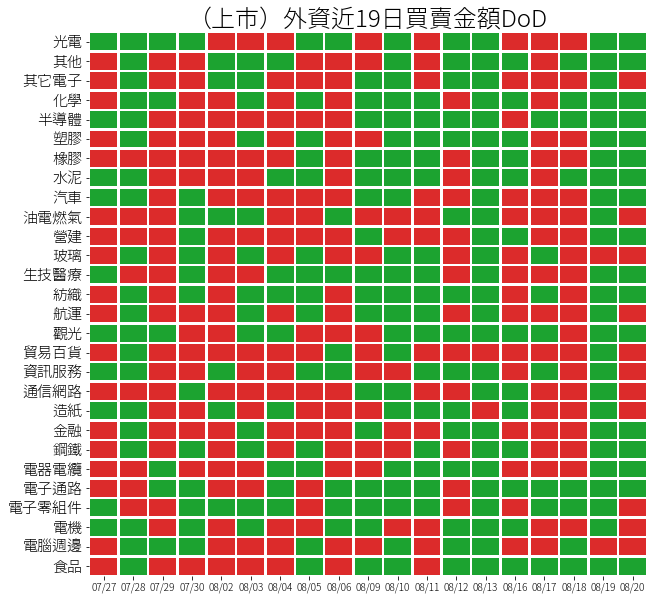

In [7]:
fig = plt.figure(figsize = (10,10))
seaborn.heatmap(fi_stock_dod.iloc[:,1:],cmap = ['#1ca330','#dc2b2b']  , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上市）外資近19日買賣金額DoD' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/上市_外資_金額DoD.png'.format(data_date))

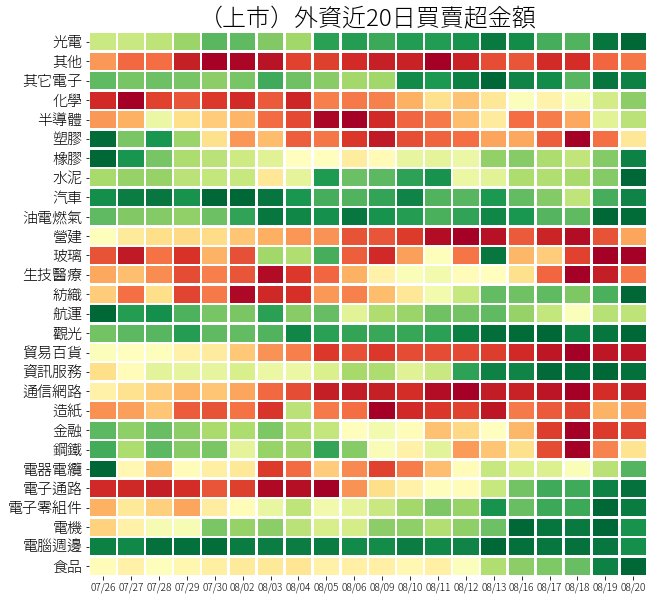

In [8]:
fig = plt.figure(figsize = (10,10))
seaborn.heatmap(fi_stock,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上市）外資近20日買賣超金額' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/上市_外資.png'.format(data_date))

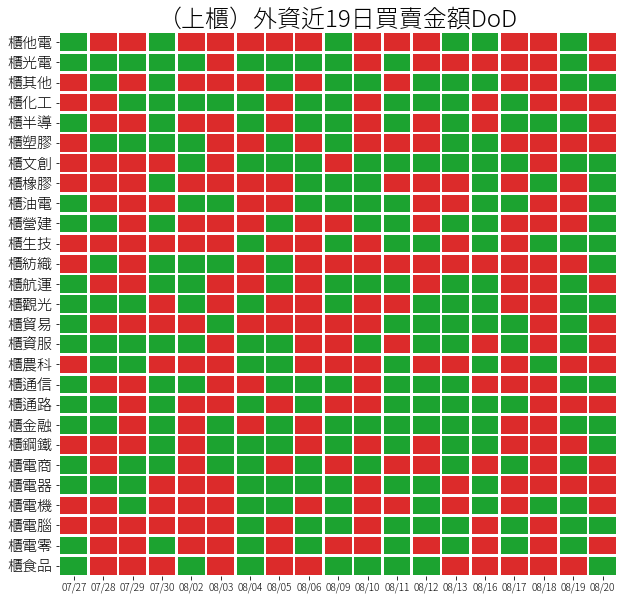

In [9]:
fig = plt.figure(figsize = (10,10))
seaborn.heatmap(fi_otc_dod.iloc[:,1:],cmap = ['#1ca330','#dc2b2b'] , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xticks(None)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上櫃）外資近19日買賣金額DoD' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/上櫃_外資_金額DoD.png'.format(data_date))

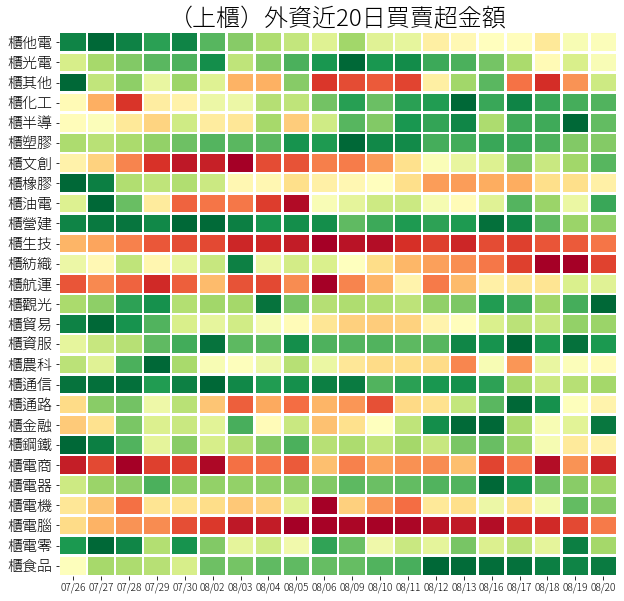

In [10]:
fig = plt.figure(figsize = (10,10))
seaborn.heatmap(fi_otc,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15,rotation = 360)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上櫃）外資近20日買賣超金額' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/上櫃_外資.png'.format(data_date))

In [11]:
fig = plt.figure(figsize = (12,30))
seaborn.heatmap(fi_topic_dod.iloc[:,1:],cmap = ['#1ca330','#dc2b2b']  , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xticks()
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上市）外資近19日買賣金額DoD' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/題材_外資_金額DoD.png'.format(data_date))

Error in callback <function flush_figures at 0x7f6640184e50> (for post_execute):


KeyboardInterrupt: 

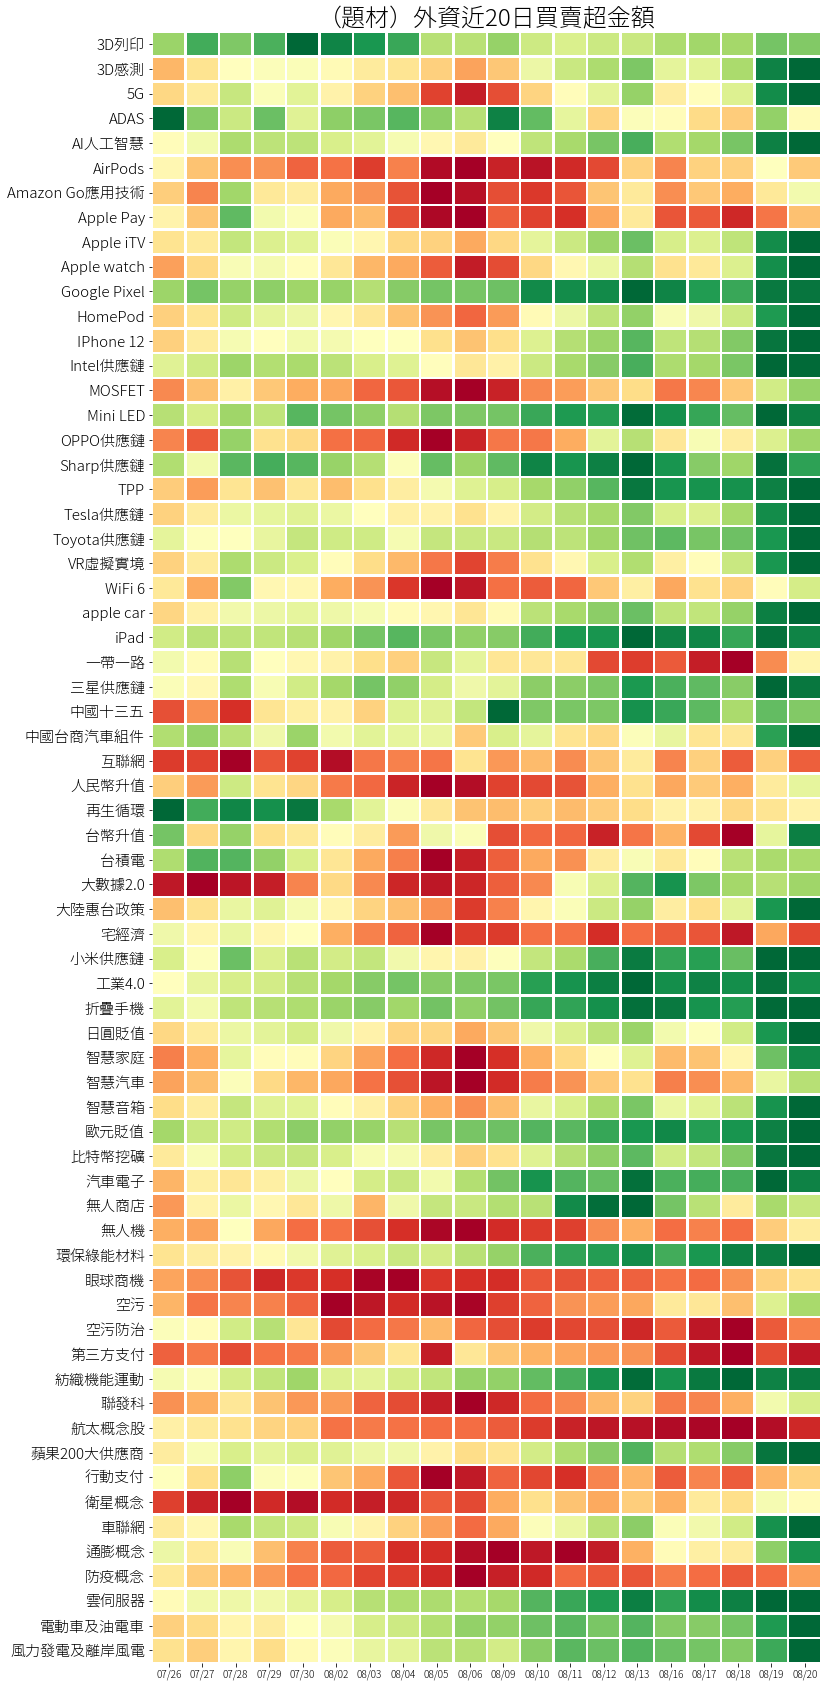

In [12]:
fig = plt.figure(figsize = (12,30))
seaborn.heatmap(fi_topic,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（題材）外資近20日買賣超金額' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/題材_外資.png'.format(data_date))

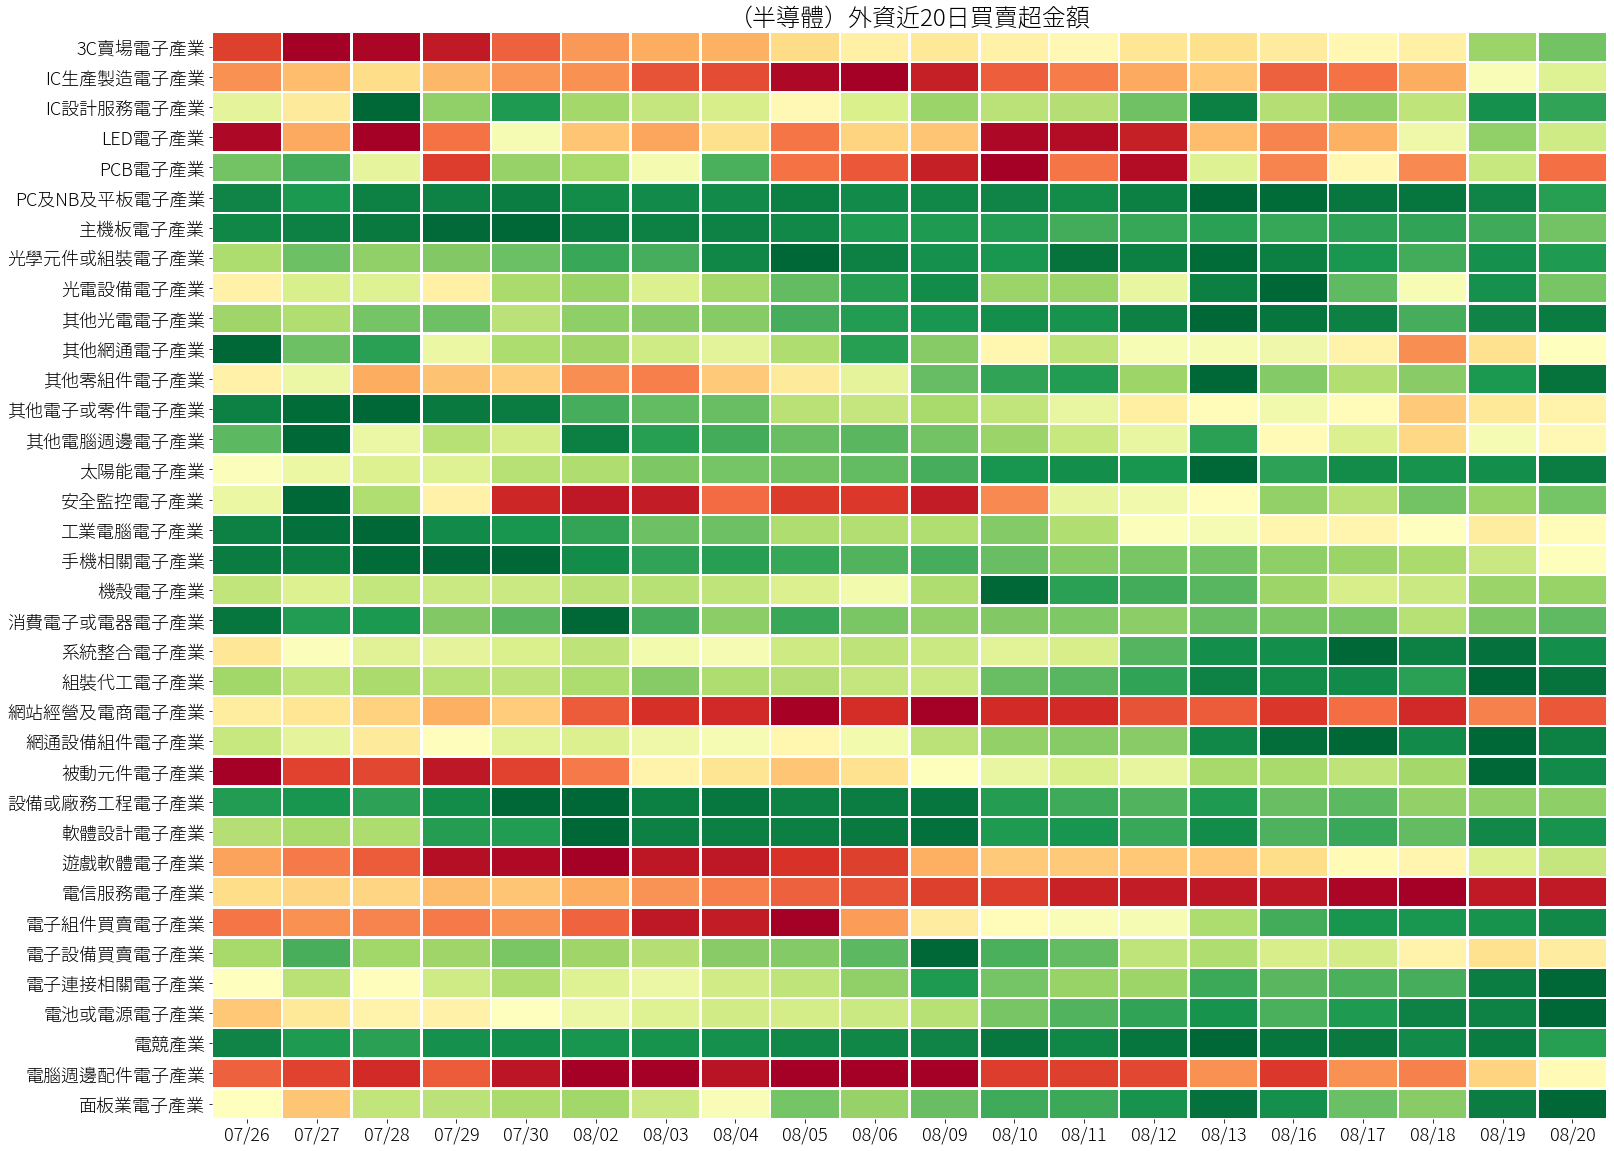

In [13]:
fig = plt.figure(figsize = (25,20))
seaborn.heatmap(fi_semi,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（半導體）外資近20日買賣超金額' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/半導體_外資.png'.format(data_date))

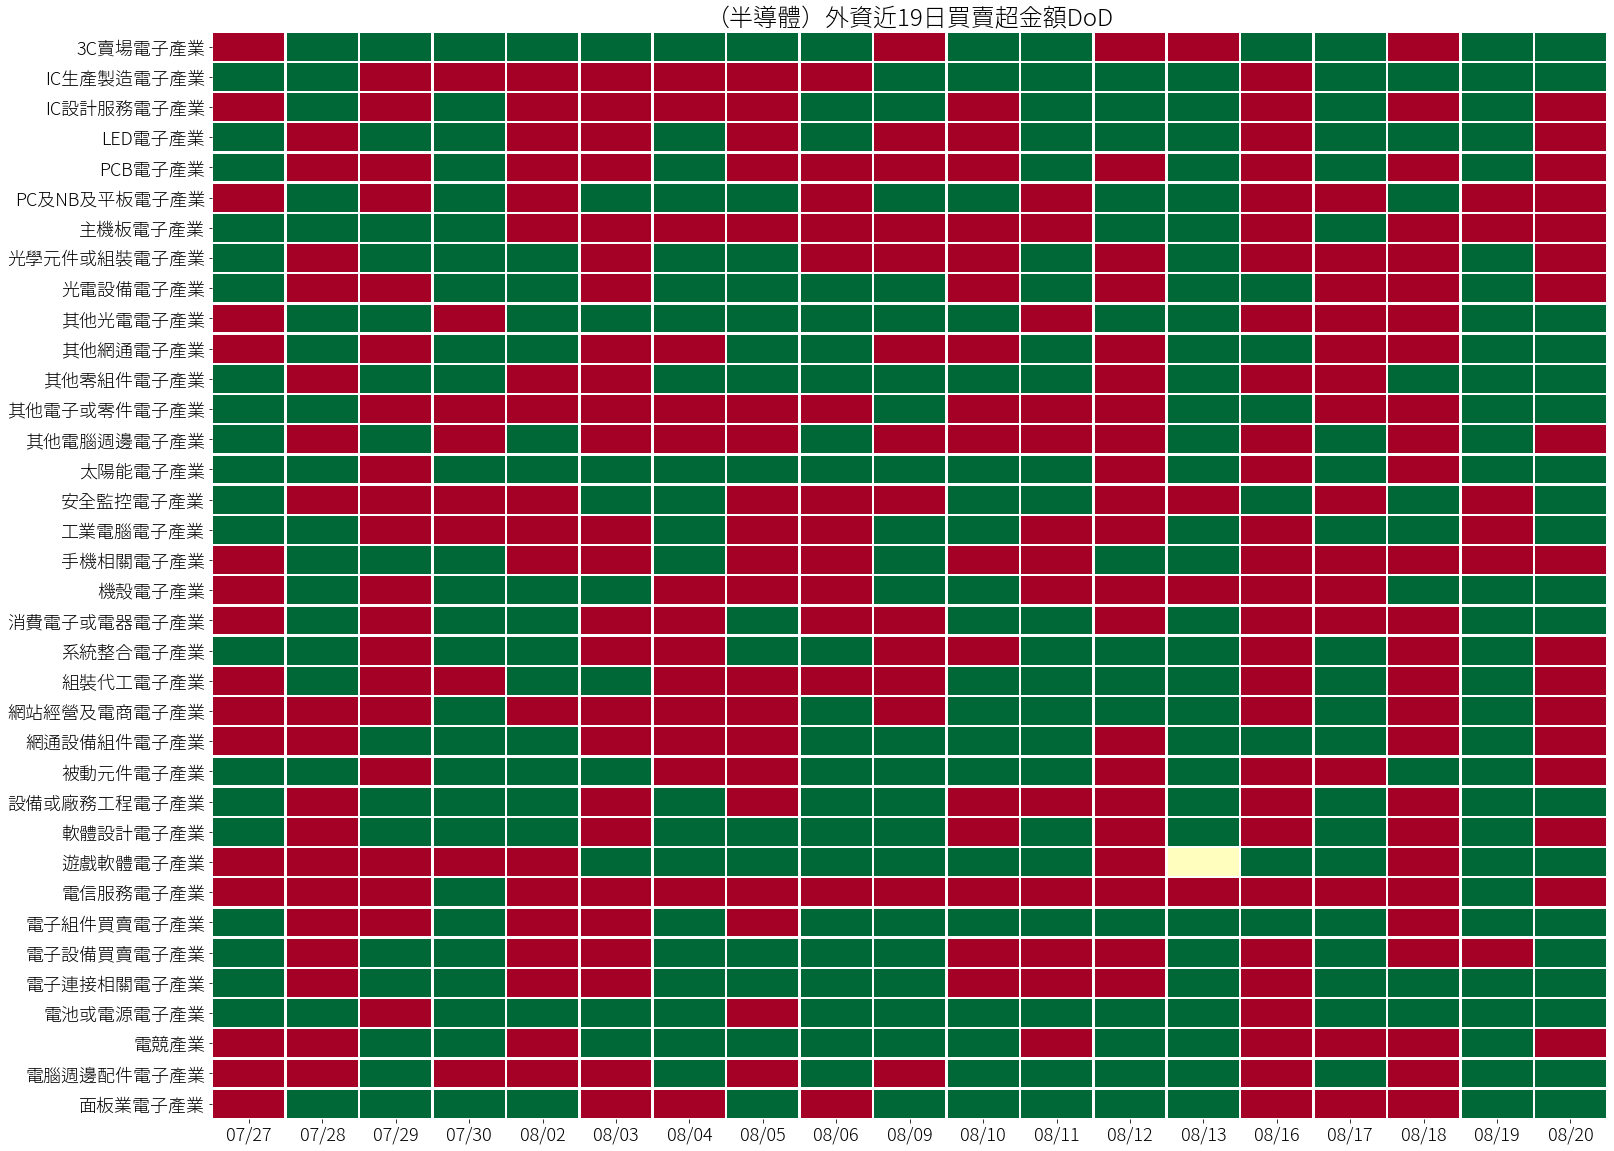

In [14]:
fig = plt.figure(figsize = (25,20))
seaborn.heatmap(fi_semi_dod.iloc[:,1:],cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（半導體）外資近19日買賣超金額DoD' , fontsize = 24)
plt.savefig('/home/buneo/Stock/exponent_chart/{0}/半導體_外資DoD.png'.format(data_date))

fig = plt.figure(figsize = (10,10))
seaborn.heatmap(it_stock,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上市）投信近20日買賣超金額' , fontsize = 24)
plt.savefig('exponent_chart/{0}/上市_投信.png'.format(data_date))

fig = plt.figure(figsize = (22,20))
seaborn.heatmap(it_semi,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（半導體）投信近20日買賣超金額' , fontsize = 24)
plt.savefig('exponent_chart/{0}/半導體_投信.png'.format(data_date))

fig = plt.figure(figsize = (10,10))
seaborn.heatmap(it_otc,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15,rotation = 360)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（上櫃）投信近20日買賣超金額' , fontsize = 24)
plt.savefig('exponent_chart/{0}/上櫃_投信.png'.format(data_date))

fig = plt.figure(figsize = (12,30))
seaborn.heatmap(it_topic,cmap = 'RdYlGn_r' , cbar = False,linewidths=1.5)
plt.yticks(fontsize = 15)
plt.xlabel(xlabel = '')
plt.ylabel(ylabel = '')
plt.title('（題材）投信近20日買賣超金額' , fontsize = 24)
plt.savefig('exponent_chart/{0}/題材_投信.png'.format(data_date))